In [45]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle

import regionmask
import xarray as xr

import matplotlib.pyplot as plt
import plotly.express as px

from joblib import dump, load

from tqdm import tqdm

In [46]:
LAND_FEATURES = ['c3ann', 'c3nfx', 'c3per','c4ann', 'c4per',
 'pastr', 'primf', 'primn', 'range', 'secdf', 'secdn', 'urban', 'cell_area']

LAND_DIFF_FEATURES = ['c3ann_diff', 'c3nfx_diff', 'c3per_diff','c4ann_diff', 'c4per_diff',
 'pastr_diff', 'primf_diff', 'primn_diff', 'range_diff', 'secdf_diff', 'secdn_diff', 'urban_diff']

#FEATURES = LAND_DIFF_FEATURES
FEATURES = LAND_DIFF_FEATURES
LABEL = 'ELUC'

# Great Britain, France, Germany, Netherlands, Belgium, Switzerland, Ireland
COUNTRY_NAME_LIST = ["GB", "F", "D", "NL", "B", "CH", "IRL"]

DATA_FILE_PATH = "../data/gcb/merged_aggregated_dataset_1850_2022.zarr.zip"
UPDATE_FILE_PATH = "../data/gcb/BLUE_LUH2-GCB2022_ELUC-committed_gridded_net_1850-2021.nc"

MANUAL_MAP = {
    "INDO": 360,
    "DRC": 180,
    "RUS": 643,
    "N": 578,
    "F": 250,
    "J": 388,
    "NA": 516,
    "PAL": 275,
    "J": 400,
    "IRQ": 368,
    "IND": 356,
    "IRN": 364,
    "SYR": 760,
    "ARM": 51,
    "S": 752,
    "A": 36,
    "EST": 233,
    "D": 276,
    "L": 442,
    "B": 56,
    "P": 620,
    "E": 724,
    "IRL": 372,
    "I": 380,
    "SLO": 705,
    "FIN": 246,
    "J": 392,
    "BiH": 70,
    "NM": 807,
    "KO": 383,
    "SS": 728
}

countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
countries_df = countries.to_dataframe()


In [47]:
print(countries_df.head())
print(countries_df[countries_df["abbrevs"] == "GB"].index)

        abbrevs                     names
numbers                                  
0            FJ                      Fiji
1            TZ                  Tanzania
2            WS                 W. Sahara
3            CA                    Canada
4            US  United States of America
Int64Index([143], dtype='int64', name='numbers')


## Data Preprocessing

In [48]:
def import_data(path, update_path):
    raw = xr.open_zarr(path, consolidated=True)

    # Get updated ELUC
    if update_path:
        eluc = xr.open_dataset(update_path)
        raw = raw.drop_vars(["ELUC", "cell_area"])
        raw = raw.merge(eluc)

    # Shift actions back a year
    raw[LAND_DIFF_FEATURES] = raw[LAND_DIFF_FEATURES].shift(time=-1)

    # Old time shifting
    # raw['ELUC'] = raw['ELUC'].shift(time=1)
    # raw['ELUC_diff'] = raw['ELUC_diff'].shift(time=1)
    # raw['time'] = raw.time - 1
    # assert(list(np.unique(raw.time)) == list(range(1849, 2022)))

    mask = raw["ELUC_diff"].isnull().compute()
    raw = raw.where(~mask, drop=True)

    country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask(raw)
    raw["country"] = country_mask
    return raw

In [49]:
def da_to_df(da):
    df = da.to_dataframe()
    df = df.dropna()
    df['country_name'] = countries_df.loc[df['country'], 'names'].values
    return df

def process_input(da):
    da = da[FEATURES + [LABEL]]
    df = da.to_dataframe()
    df = df.dropna()

    return df[FEATURES], df[LABEL]

In [50]:
class Scaler:
    def __init__(self):
        self.means = None
        self.stdevs = None

    def fit(self, X_train):
        self.means = X_train.mean(axis=0)
        self.stdevs = X_train.std(axis=0)
        # Replace 0 stdevs with 1 so we don't divide by 0
        self.stdevs = self.stdevs.replace(0, 1)

    def transform(self, X):
        return (X - self.means) / self.stdevs
    
    def fit_transform(self, X_train):
        self.fit(X_train)
        return self.transform(X_train)

In [51]:
def create_country_dataset(ds, country_name_list, first_train_year, last_train_year, scale=False, verbose=False):
    country_id_list = countries_df.index[countries_df["abbrevs"].isin(country_name_list)].values
    train_da, test_da = None, None
    if len(country_id_list) == 1:
        test_da = ds.where(ds["country"] == country_id_list[0], drop=True).where(ds.time > last_train_year, drop=True).load()
        train_da = ds.where(ds["country"] == country_id_list[0], drop=True).where((ds.time <= last_train_year) & (ds.time >= first_train_year), drop=True).load()
    else:
        c_mask = xr.DataArray(np.in1d(ds["country"], country_id_list).reshape(ds["country"].shape),
                              dims=ds["country"].dims, coords=ds["country"].coords)
        test_da = ds.where(c_mask, drop=True).where(ds.time > last_train_year, drop=True).load()
        train_da = ds.where(c_mask, drop=True).where(ds.time <= last_train_year, drop=True).load() # 143 is the code for the UK

    X_train, y_train = process_input(train_da)
    X_test, y_test = process_input(test_da)
    
    if scale:
        scaler = Scaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    if verbose:
        print(X_train.shape)
        print(X_test.shape)

    return {"Train": {"X": X_train,
                      "y": y_train},
            "Test": {"X": X_test,
                      "y": y_test}}

In [52]:
print("Loading data...")
raw = import_data(DATA_FILE_PATH, UPDATE_FILE_PATH)
data = create_country_dataset(raw, COUNTRY_NAME_LIST, 1982, 2011, verbose=True)


Loading data...


/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of c

(435183, 12)
(27030, 12)


## Model

In [53]:
X_train, y_train = shuffle(data["Train"]["X"], data["Train"]["y"], random_state=42)

# model = XGBRegressor(random_state=42, n_jobs=-1)
model = RandomForestRegressor(random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(data["Test"]["X"])
print(f"MAE: {mean_absolute_error(data['Test']['y'], pred)}")

# TODO: uncomment this to write model to file
# dump(model, "../demo/predictors/ELUC_forest.joblib")

MAE: 0.03661973635413101


In [54]:
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(data["Test"]["X"])
print(f"MAE: {mean_absolute_error(data['Test']['y'], pred)}")

MAE: 0.03327479958534241


### Train by latitude

In [55]:
df = da_to_df(raw)
df.head()

ELUC_diff         c3ann    c3ann_diff         c3nfx  \
time lat     lon                                                               
1851 -55.375 -69.375  1.585186e-04  1.529372e-07 -1.466177e-09  0.000000e+00   
             -69.125 -1.669832e-09  6.256299e-08 -4.925624e-10  8.209591e-09   
             -68.875  3.134616e-07  2.541674e-08  3.165289e-08  0.000000e+00   
             -68.625 -2.126626e-08  6.788947e-08 -7.737526e-10  0.000000e+00   
             -68.375 -8.974894e-09  1.061018e-06 -5.096126e-09  0.000000e+00   

                        c3nfx_diff         c3per    c3per_diff         c4ann  \
time lat     lon                                                               
1851 -55.375 -69.375  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
             -69.125 -6.463452e-11  1.742937e-08 -1.372218e-10  8.359032e-09   
             -68.875  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
             -68.625  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
             -68.375  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                        c4ann_diff  c4per  ...    secdf_diff     secdn  \
time lat     lon                           ...                           
1851 -55.375 -69.375  0.000000e+00    0.0  ...  1.048539e-04  0.000000   
             -69.125 -6.581136e-11    0.0  ... -1.396984e-09  0.000000   
             -68.875  0.000000e+00    0.0  ...  0.000000e+00  0.000034   
             -68.625  0.000000e+00    0.0  ...  0.000000e+00  0.000038   
             -68.375  0.000000e+00    0.0  ...  0.000000e+00  0.000044   

                        secdn_diff  urban  urban_diff          ELUC  \
time lat     lon                                                      
1851 -55.375 -69.375  0.000000e+00    0.0         0.0  4.283220e-03   
             -69.125  0.000000e+00    0.0         0.0 -3.430041e-07   
             -68.875 -3.637979e-12    0.0         0.0  3.217266e-06   
             -68.625  5.940819e-09    0.0         0.0 -7.565677e-08   
             -68.375 -3.637979e-12    0.0         0.0 -3.761452e-07   

                         cell_area  mask  country  country_name  
time lat     lon                                                 
1851 -55.375 -69.375  43908.949219   1.0     10.0         Chile  
             -69.125  43908.949219   1.0     10.0         Chile  
             -68.875  43908.949219   1.0     10.0         Chile  
             -68.625  43908.949219   1.0     10.0         Chile  
             -68.375  43908.949219   1.0     10.0         Chile  

[5 rows x 31 columns]

In [56]:
df[df["ELUC"] == 0]["country_name"].value_counts()

Russia                      4440101
Canada                      2443603
Greenland                   1773337
Australia                   1043477
United States of America     798714
                             ...   
South Korea                       2
Bangladesh                        2
Georgia                           2
Moldova                           1
Germany                           1
Name: country_name, Length: 139, dtype: int64

In [57]:
zero = df[df["ELUC"] == 0].copy()
zero["change"] = zero[zero[LAND_DIFF_FEATURES] > 0].sum(axis=1)

In [58]:
zero = zero.sort_values("change", ascending=False)
zero.iloc[0]

ELUC_diff            -0.003498
c3ann                      0.0
c3ann_diff                 0.0
c3nfx                      0.0
c3nfx_diff                 0.0
c3per                      0.0
c3per_diff                 0.0
c4ann                      0.0
c4ann_diff                 0.0
c4per                      0.0
c4per_diff                 0.0
cell_area_diff    73229.828125
pastr                      0.0
pastr_diff                 0.0
primf                      0.0
primf_diff                 0.0
primn                 0.794652
primn_diff           -0.794652
range                      0.0
range_diff                 1.0
secdf                      0.0
secdf_diff                 0.0
secdn                 0.205348
secdn_diff           -0.205348
urban                      0.0
urban_diff                 0.0
ELUC                       0.0
cell_area         73229.828125
mask                       1.0
country                   14.0
country_name             Sudan
change                     1.0
Name: (2

In [60]:
lat_zones = [(0, 23.5), (23.5, 40), (40, 60), (60, 90)]
train_year_range = (1982, 2012)
idx_vals = df.index.get_level_values('lat')
for i, zone in enumerate(lat_zones):
    pos = (idx_vals >= zone[0]) & (idx_vals < zone[1])
    neg = (idx_vals <= -zone[0]) & (idx_vals > -zone[1])
    df_zone = df.loc[(pos) | (neg)]
    df_zone = df.loc[pos]

    time_vals = df_zone.index.get_level_values('time')
    train = df_zone.loc[(time_vals >= train_year_range[0]) & (time_vals < train_year_range[1])]
    test = df_zone.loc[(time_vals >= train_year_range[1])]
    X_train = train[FEATURES]
    y_train = train[LABEL]
    X_test = test[FEATURES]
    y_test = test[LABEL]

    model = LinearRegression(n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Zone: {zone} mae: {mean_absolute_error(y_test, y_pred)}")
    dump(model, f"../demo/predictors/zone{i}_linear.joblib")

Zone: (0, 23.5) mae: 0.10196232050657272
Zone: (23.5, 40) mae: 0.09912386536598206
Zone: (40, 60) mae: 0.06248398497700691
Zone: (60, 90) mae: 0.006578302476555109


### Train for every country

In [12]:
def train_country_model(X_train, y_train, X_test, y_test):
    model = LinearRegression(n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model, mean_absolute_error(y_test, y_pred)

In [19]:
models = []
maes = []
for country in list(countries_df["abbrevs"]):
    country_name = countries_df[countries_df["abbrevs"] == country]["names"].iloc[0]
    data = create_country_dataset(raw, country_mask, [country], 1982, 2011)
    X_train = data["Train"]["X"]
    y_train = data["Train"]["y"]
    X_test = data["Test"]["X"]
    y_test = data["Test"]["y"]

    if len(X_train) == 0:
        print(f"{country_name} has no data")
        models.append(None)
        maes.append(1)
    else:
        model, mae = train_country_model(X_train, y_train, X_test, y_test)

        print(f"{country_name}: {mae}")
        models.append(model)
        maes.append(mae)

Fiji: 0.0006945133209228516
Tanzania: 0.11322583258152008
W. Sahara: 4.435848186706316e-14
Canada: 0.007898674346506596
United States of America: 0.03166184946894646
Kazakhstan: 0.00505554024130106
Uzbekistan: 0.0034026254434138536
Papua New Guinea: 0.009446265175938606
Indonesia: 0.09128442406654358
Argentina: 0.02587825432419777
Chile: 0.05365749076008797
Dem. Rep. Congo: 0.07600587606430054
Somalia: 0.003999932669103146
Kenya: 0.021350150927901268
Sudan: 0.0037722184788435698
Chad: 0.0019041928462684155
Haiti: 0.168892964720726
Dominican Rep.: 0.03669315576553345
Russia: 0.029004765674471855
Bahamas: 0.0006989007233642042
Falkland Is.: 1.7366366154866715e-19
Norway: 0.006762273143976927
Greenland: 4.7595399621513934e-08
Fr. S. Antarctic Lands: 0.0
Timor-Leste: 0.006666526198387146
South Africa: 0.009950254112482071
Lesotho: 0.043607939034700394
Mexico: 0.2337242066860199
Uruguay: 0.01772516407072544
Brazil: 0.23421885073184967
Bolivia: 0.08533409982919693
Peru: 0.10230658203363419
C

We lost kosovo and south sudan

In [14]:
def manual_map(code):
    return MANUAL_MAP[code] if code in MANUAL_MAP.keys() else np.nan

def map_plot_results(maes):
    results_df = pd.DataFrame({"name": list(countries_df["names"]), "code": list(countries_df["abbrevs"]), "mae": maes})
    print(results_df.shape)
    results_df["num"] = results_df["code"].apply(manual_map)
    codes_df = pd.read_csv("../data/gcb/conversion/codes.csv")
    merged_alpha = results_df.merge(codes_df, how="inner", left_on="code", right_on="Alpha-2 code")
    print(merged_alpha.shape)
    merged_num = results_df.merge(codes_df, how="inner", left_on="num", right_on="Numeric code")
    print(merged_num.shape)

    final = pd.concat([merged_alpha, merged_num])
    print(final.shape)

    print(results_df[~results_df["name"].isin(final["name"])])

    fig=px.choropleth(final, locations="Alpha-3 code", color="mae", hover_name="English short name lower case")
    fig.show()

In [55]:
map_plot_results(maes)

Bad pipe message: %s [b'\x99y\xd9\xe1\xad\x02\x9f\xf7>\xdc\xb0:\xa6\x92\xb4mT\xe7\x00\x01p\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05']
Bad pipe message: %s [b".e\x8a\xb4K\xdabb%\xb6\xf3\xbd\x83=z'\xa0\x8a\x00\x01p\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00A\x00B\x00C\x00D\x00E\x00F\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0\x0e\xc0\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15\xc0\x16\xc0\x17\xc0"]

### One big model

In [16]:
big_data = create_country_dataset(raw, country_mask, list(countries_df["abbrevs"]), 1982, 2011)
big, big_mae = train_country_model(big_data["Train"]["X"], big_data["Train"]["y"], big_data["Test"]["X"], big_data["Test"]["y"])
print(f"Overall mae: {big_mae}")
big_maes = []
for country in list(countries_df["abbrevs"]):
    country_name = countries_df[countries_df["abbrevs"] == country]["names"].iloc[0]
    data = create_country_dataset(raw, country_mask, [country], 1982, 2011)
    X_train = data["Train"]["X"]
    y_train = data["Train"]["y"]
    X_test = data["Test"]["X"]
    y_test = data["Test"]["y"]

    if len(X_test) == 0:
        print(f"{country_name} has no data")
        big_maes.append(1)
    else:
        mae = mean_absolute_error(y_test, big.predict(X_test))
        print(f"{country_name}: {mae}")
        big_maes.append(mae)


Overall mae: 0.07237880676984787
Fiji: 0.25998103618621826
Tanzania: 0.11994694918394089
W. Sahara: 0.002217766596004367
Canada: 0.01196061260998249
United States of America: 0.03655775263905525
Kazakhstan: 0.0142451710999012
Uzbekistan: 0.026681696996092796
Papua New Guinea: 0.02410385012626648
Indonesia: 0.34527745842933655
Argentina: 0.0327833890914917
Chile: 0.059066932648420334
Dem. Rep. Congo: 0.21269537508487701
Somalia: 0.00844794325530529
Kenya: 0.053222499787807465
Sudan: 0.04614444449543953
Chad: 0.04520940035581589
Haiti: 0.22964303195476532
Dominican Rep.: 0.062421295791864395
Russia: 0.04026629775762558
Bahamas: 0.003052665153518319
Falkland Is.: 0.002015135483816266
Norway: 0.019621944054961205
Greenland: 0.0021683198865503073
Fr. S. Antarctic Lands: 0.002146318554878235
Timor-Leste: 0.33240267634391785
South Africa: 0.014962580986320972
Lesotho: 0.4382367730140686
Mexico: 0.23798789083957672
Uruguay: 0.30537712574005127
Brazil: 0.2265893816947937
Bolivia: 0.065740376710

In [17]:
map_plot_results(big_maes)

(177, 3)
(146, 9)
(29, 9)
(175, 9)
         name code       mae    num
174    Kosovo   KO  0.151735  383.0
176  S. Sudan   SS  0.137074  728.0


#### Plot differences between individual models and general one

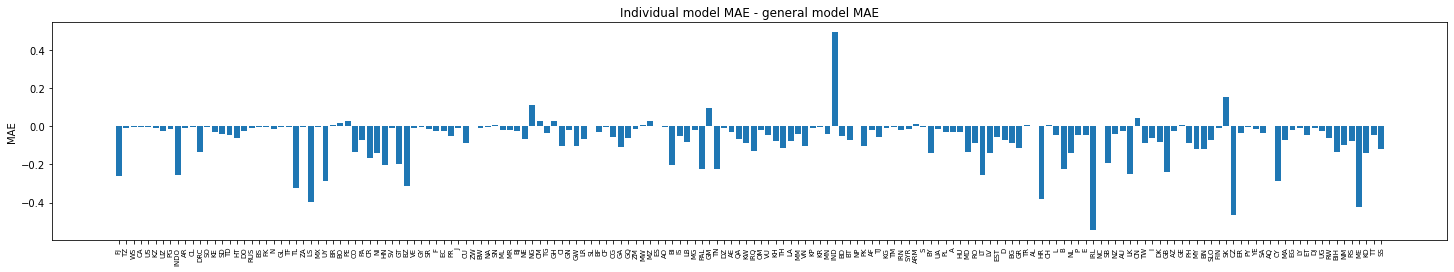

In [29]:
diffs = [mae - big_mae for mae, big_mae in zip(maes, big_maes)]
plt.figure(figsize=(25, 4))
plt.title("Individual model MAE - general model MAE")
plt.ylabel("MAE")
plt.bar(countries_df["abbrevs"], diffs)
plt.xticks(rotation=90, fontsize=7)
plt.show()

### Tune on neighboring countries

In [59]:
def k_nearest_countries(country_id, k):
    codes_df = pd.read_csv("../data/gcb/conversion/codes.csv")
    neighbor_df = pd.read_csv("../data/gcb/conversion/neighbors.csv")
    three_code = codes_df[codes_df["Alpha-2 code"] == country_id]["Alpha-3 code"].iloc[0]
    
    idx = 0
    queue = [three_code]
    seen = set([three_code])
    # Simple BFS to find neighbors
    # Add one because the first element in the queue is our original country
    while idx < len(queue) and len(queue) < k + 1:
        curr = queue[idx]
        neighbors = neighbor_df[neighbor_df["country_code"] == curr]["neighbor_code"]
        for neighbor in list(neighbors):
            if neighbor not in seen:
                queue.append(neighbor)
        idx += 1
    
    if len(queue) > 1:
        return [codes_df[codes_df["Alpha-3 code"] == code]["Alpha-2 code"].iloc[0] for code in queue[1:k+1]]
    
    return []

In [69]:
def find_model_for_country(country_id, raw, country_mask):
    print(f"Finding best model for {country_id}")
    country_data = create_country_dataset(raw, country_mask, [country_id], 1982, 2011)
    X_train = country_data["Train"]["X"]
    y_train = country_data["Train"]["y"]
    X_test = country_data["Test"]["X"]
    y_test = country_data["Test"]["y"]

    print(X_train.shape)
    print(y_train.shape)

    best_model, best_mae = train_country_model(X_train, y_train, X_test, y_test)
    best_countries = [country_id]
    print(f"Baseline score: {best_mae}")

    countries = [country_id]
    k_nearest = k_nearest_countries(country_id, 5)
    print(f"Neighbors: {k_nearest}")
    for neighbor in k_nearest:
        print(f"Adding neighbor: {neighbor}")
        countries.append(neighbor)
        data = create_country_dataset(raw, country_mask, countries, 1982, 2011)
        print(X_train.shape)
        print(y_train.shape)
        model, mae = train_country_model(X_train, y_train, X_test, y_test)
        print(f"Score: {mae}")
        if mae < best_mae:
            best_model = model
            best_countries = countries
            best_mae = mae

    return best_model, best_mae, best_countries

In [70]:
best_model, best_mae, best_countries = find_model_for_country("GB", raw, country_mask)

Finding best model for GB
(15060, 12)
(15060,)
Baseline score: 0.07678873091936111
Neighbors: ['IE']
Adding neighbor: IE
(30120, 12)
(30120,)
Score: 0.07677499204874039


### Tune on best year to train on

In [16]:
def find_best_year(raw, country_mask, country_list):
    X_train = pd.DataFrame(columns=FEATURES)
    y_train = pd.Series(name=LABEL, dtype=float)
    X_test = None
    y_test = None
    years = list(range(2012, 1851, -10))
    maes = []
    best_model = None
    best_mae = None
    for i in range(1, len(years)):
        print(f"Adding {years[i]}-{years[i-1]-1} to train set...")
        data = create_country_dataset(raw, country_mask, country_list, years[i], years[i-1]-1)
        X_train = pd.concat((X_train, data["Train"]["X"]), axis=0)
        y_train = pd.concat((y_train, data["Train"]["y"]))
        if i == 1:
            X_test = data["Test"]["X"]
            y_test = data["Test"]["y"]

        model = RandomForestRegressor(random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, pred)
        print(f"MAE: {mae}")
        maes.append(mae)

        if not best_mae or best_mae > mae:
            best_model = model
            best_mae = mae
    
    plt.plot(years[1:], maes)
    plt.xticks(rotation=90)
    plt.title(f"Year train set started vs. MAE for {' '.join(country_list)}")
    plt.xlabel("Year")
    plt.ylabel("MAE")
    plt.show()

    return best_model, maes
        

Adding 2002-2011 to train set...
MAE: 0.03648469909050712
Adding 1992-2001 to train set...
MAE: 0.03710089250796529
Adding 1982-1991 to train set...
MAE: 0.037174860283775146
Adding 1972-1981 to train set...
MAE: 0.037956103687055286
Adding 1962-1971 to train set...
MAE: 0.038082952563230514
Adding 1952-1961 to train set...
MAE: 0.03796119643580342
Adding 1942-1951 to train set...
MAE: 0.037907506265799785
Adding 1932-1941 to train set...
MAE: 0.03792129119454972
Adding 1922-1931 to train set...
MAE: 0.03834665424151246
Adding 1912-1921 to train set...
MAE: 0.03839517526179118
Adding 1902-1911 to train set...
MAE: 0.03840008108683362
Adding 1892-1901 to train set...
MAE: 0.03820898943408478
Adding 1882-1891 to train set...
MAE: 0.038035298970404495
Adding 1872-1881 to train set...
MAE: 0.037873564280927814
Adding 1862-1871 to train set...
MAE: 0.03822668028038931
Adding 1852-1861 to train set...
MAE: 0.03859580199673611


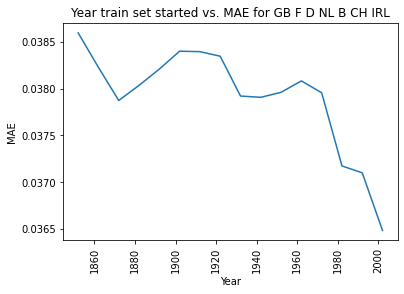

In [17]:
best_model, maes = find_best_year(raw, country_mask, COUNTRY_NAME_LIST)

## Model Analysis

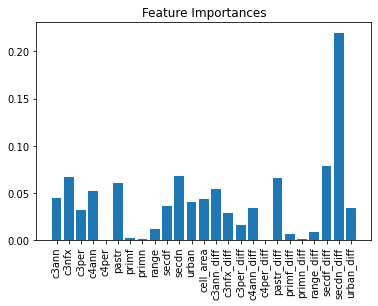

In [20]:
plt.bar(data["Train"]["X"].columns, model.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature Importances")
plt.show()

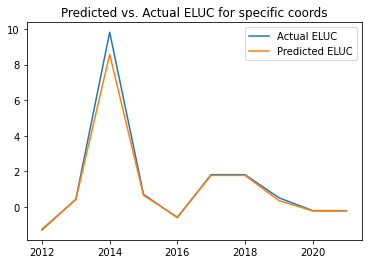

In [19]:
X_irl = data["Test"]["X"].loc[:, 54.125, -6.875]
y_irl = data["Test"]["y"].loc[:, 54.125, -6.875]

preds = model.predict(X_irl)

times = list(data["Test"]["X"].index.unique(level="time"))
plt.title("Predicted vs. Actual ELUC for specific coords")
plt.plot(times, y_irl, label="Actual ELUC")
plt.plot(times, preds, label="Predicted ELUC")
plt.legend()
plt.show()

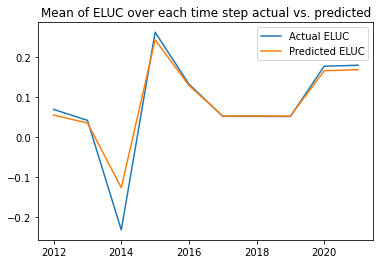

In [20]:
preds = model.predict(data["Test"]["X"])
test_copy = data["Test"]["X"].copy()
test_copy["pred"] = preds
test_copy["ELUC"] = data["Test"]["y"]
pred_eluc_sums = []
eluc_sums = []
for time in times:
    pred_eluc_sums.append(test_copy.loc[time, :, :]["pred"].mean())
    eluc_sums.append(test_copy.loc[time, :, :]["ELUC"].mean())

plt.title("Mean of ELUC over each time step actual vs. predicted")
plt.plot(times, eluc_sums, label="Actual ELUC")
plt.plot(times, pred_eluc_sums, label="Predicted ELUC")
plt.legend()
plt.show()